# What are the effects of different C-Rates on capacity?

## Purpose
[!] This notebook is apart of a series of queries aimed at answering personal questions with supported physics-based models designed to further extend experience, knowledge and application of electrochemsitry across various battery contexts. <br>
For the query outlined: We aim to understand the effects of c-rates on capacity based on research and supporting theories with modeled data.

## Description
In this notebook, we will:
- **Import necessary libraries**: Load essential Python libraries, primarily PyBaMM for supported physics-based analyses.
- **Lay out queries**: Outline questions and procured answers to said questions.
- **Verify against modeled data**: Support various queries with modeled data from PyBaMM.
- **Visualization**: Create visual representations of the results to enhance understanding.

## Author
*Javaid Baksh*  
*Date: January 11, 2025*

## Additional Information
- **Keywords**: -
- **References**: <br>
  - [1] Sullivan, J. (2016). The effects of charge/discharge rate on capacity fade of lithium ion batteries. Ph.D. Thesis.
  - [2] Deng, Y., et al. (2019). Quantifying the factors limiting rate performance in battery electrodes. Nature Communications, 10(1), 1-10.

In [14]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [15]:
model = pybamm.lithium_ion.SPMe()
parameter_values = pybamm.ParameterValues("Chen2020")

In [16]:
def pybamm_experiment(C_rate):
    return pybamm.Experiment(
    [
        f"Charge at {C_rate:.2f}C until 4.2V",
        # "Rest for 1 hour"
        # f"Discharge at {C_rate:.2f}C until 3.0V"
    ]
)

In [17]:
# [x for x in list(parameter_values.keys()) if 'cap' in x]

# Queries
## What are the effects of increasing C-Rate on capacity and why does this occur?

It is a well-known phenomenon that available capacity is decreased with increasing C-Rates. Examples of this being conveyed can be seen below: <br>
- [1] "As the charge and discharge rates increase, the mechanical degradation of active particles becomes more pronounced, leading to a significant reduction in capacity." <br>
- [2] "The results indicate that as the C-rate increases, the effective capacity decreases significantly due to limitations in ionic transport within the electrode materials."

#### Rate Capability
Firstly, to support the relation between C-Rate and available capacity with physics-based models, let's visualize the available capacity against increasing C-Rates with a rate capability plot:

In [18]:
C_rates = np.linspace(0.5, 3, 6)  # From 0.05C to 5C
discharging_capacities = np.zeros_like(C_rates)

for i, C_rate in enumerate(C_rates):
    
    sim = pybamm.Simulation(model, experiment=pybamm_experiment(C_rate))
    sim.solve(initial_soc = 0.1)
    
    time = sim.solution["Time [s]"].entries
    discharge_capacity = sim.solution["Discharge capacity [A.h]"]
    discharging_capacities[i] = discharge_capacity(time[-1])

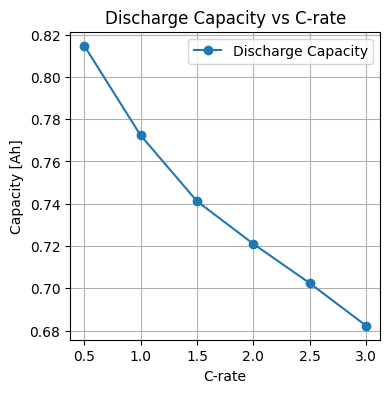

In [19]:
plt.figure(figsize=(4, 4))
plt.plot(C_rates, abs(discharging_capacities), marker='o', label='Discharge Capacity')
plt.title("Discharge Capacity vs C-rate")
plt.xlabel("C-rate")
plt.ylabel("Capacity [Ah]")
plt.grid()
plt.legend()
plt.show()

Evidently, increasing C-Rates reduce available capacity for use. What are the contributing factors to this?

### Ionic Transport
[2] states that limitations of ionic transport are a key factor, which can be connected to docs in PyBaMM below:
- From PyBaMM's docs: https://docs.pybamm.org/en/latest/source/examples/notebooks/models/tortuosity_models.html
  - Transport Efficiency: As the C-rate increases, the effective transport properties through the porous media of electrodes become critical. The concept of "transport efficiency" is defined, which incorporates factors such as porosity and tortuosity. Higher C-rates lead to increased tortuosity, resulting in greater overpotential in the electrolyte and lower terminal voltage. This indicates that ionic transport becomes less efficient at higher rates, limiting performance.
- Recall: Porosity is just volume fraction of empty space in electrode, where electrolyte takes up. Higher porosity = better ion transport but lower energy density (less active material). Tortuosity is just complexity of the path ions take.

#### Voltage (terminal and overpotential) against time
Let's verify this point:

In [20]:
model = pybamm.lithium_ion.DFN()

c_rates = [0.5, 1, 2, 5]

voltage_data = {}
overpotential_data = {}

for c_rate in c_rates:
    sim = pybamm.Simulation(model, experiment=pybamm_experiment(c_rate))
    solution = sim.solve(initial_soc = 0.1)
    
    voltage_data[c_rate] = {
        'time': solution['Time [h]'].entries,
        'voltage': solution['Terminal voltage [V]'].entries
    }
    
    overpotential_data[c_rate] = {
        'x': solution['x [m]'].entries,
        'overpotential': solution['X-averaged electrolyte overpotential [V]'].entries
    }

At t = 509.89 and h = 1.21547e-19, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 439.653, , mxstep steps taken before reaching tout.
At t = 199.653 and h = 6.26578e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.811 and h = 1.85972e-18, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.811 and h = 3.13738e-18, the corrector convergence failed repeatedly or with |h| = hmin.


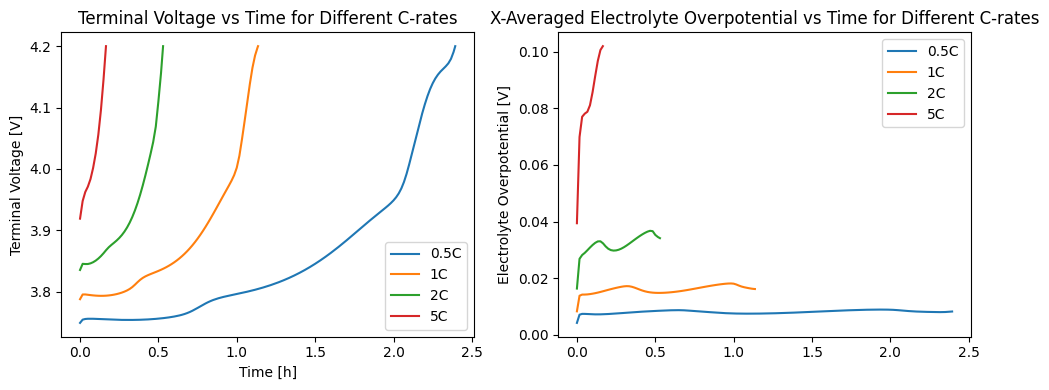

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

for c_rate, v_data in voltage_data.items():
    ax1.plot(v_data['time'], v_data['voltage'], label=f"{c_rate}C")
    ax2.plot(v_data['time'], overpotential_data[c_rate]['overpotential'], label=f"{c_rate}C")

ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Terminal Voltage [V]")
ax1.set_title("Terminal Voltage vs Time for Different C-rates")
ax1.legend()

ax1.set_xlabel("Time [h]")
ax2.set_ylabel("Electrolyte Overpotential [V]")
ax2.set_title("X-Averaged Electrolyte Overpotential vs Time for Different C-rates")
ax2.legend()

plt.tight_layout()
plt.show()

####  Ragone plot

- Recall:
  - Power density is essentially just how quickly a battery can deliver energy wrt its volume (higher power density = more power in a short time).
  - Energy density is total energy stored in battery per unit volume (higher enmergy density = more availability of storable energy for its size).
- In order for us to verify point of higher C-rates reducing available capacity, we would then expect energy density to be *higher* at lower C-rates (available stored energy), and creeping towards loss of energy density as we increase C-rate. Conversely, power output is directly proportional to applied current, so at higher C-rates we generate greater power output. In the ragone plot, we can consider increasing power density to represent higher C-rates (but we also label C-rates anyway).

In [28]:
C_rates = np.linspace(0.05, 5, 10)
capacities = np.zeros_like(C_rates)
currents = np.zeros_like(C_rates)
voltage_av = np.zeros_like(C_rates)

for i, C_rate in enumerate(C_rates):
    experiment = pybamm.Experiment(
        [f"Discharge at {C_rate:.4f}C until 3.2V"], 
        period=f"{10 / C_rate:.4f} seconds"
    )
    
    sim = pybamm.Simulation(model, experiment=experiment, solver=pybamm.CasadiSolver(dt_max=120))
    sim.solve()
    
    time = sim.solution["Time [s]"].entries
    capacities[i] = sim.solution["Discharge capacity [A.h]"](time[-1])
    currents[i] = sim.solution["Current [A]"](time[-1])
    voltage_av[i] = np.mean(sim.solution["Voltage [V]"](time))


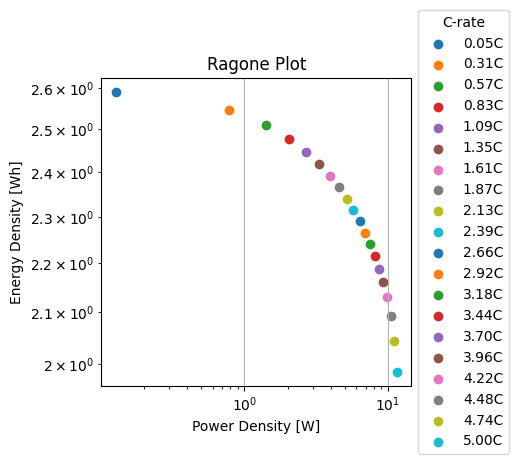

In [34]:
plt.figure(figsize=(4, 4))
for i in range(len(C_rates)):
    plt.scatter(currents[i] * voltage_av[i], capacities[i] * voltage_av[i], label=f"{C_rates[i]:.2f}C")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Power Density [W]")
plt.ylabel("Energy Density [Wh]")
plt.title("Ragone Plot")
plt.grid(True)
plt.legend(title="C-rate", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [22]:
# # Define the model
# model = pybamm.lithium_ion.DFN()

# # Define parameter values with tortuosity factors
# parameter_values = pybamm.ParameterValues("Chen2020")

# # Set tortuosity factors (example values)
# parameter_values.update({
#     "Negative electrode tortuosity factor (electrolyte)": 1.5,
#     "Positive electrode tortuosity factor (electrolyte)": 1.5,
#     "Negative electrode tortuosity factor (electrode)": 1.5,
#     "Positive electrode tortuosity factor (electrode)": 1.5,
#     "Separator tortuosity factor (electrolyte)": 1.0,
# })

In [23]:
# model = pybamm.lithium_ion.DFN(options={"transport efficiency": "tortuosity factor"})

# C_rates = np.linspace(0.1, 5, 10)  # From 0.1C to 5C
# terminal_voltages = np.zeros_like(C_rates)

# for i, C_rate in enumerate(C_rates):
#     experiment = pybamm.Experiment(
#         [f"Charge at {C_rate:.2f}C until 4.2V", f"Discharge at {C_rate:.2f}C until 3.0V"]
#     )
    
#     sim = pybamm.Simulation(model, experiment=experiment)
#     sim.solve()
    
#     # Extract terminal voltage from the solution
#     time = sim.solution["Time [s]"].entries
#     terminal_voltages[i] = sim.solution["Terminal voltage [V]"](time[-1])


In [24]:
# plt.figure(figsize=(10, 6))
# plt.plot(C_rates, terminal_voltages, marker='o')
# plt.title("Terminal Voltage vs C-rate")
# plt.xlabel("C-rate")
# plt.ylabel("Terminal Voltage [V]")
# plt.grid()
# plt.show()

Other visualizations:

In [25]:
# C_rates = [0.1, 1, 2]  # Example C-rates: 0.1C, 1C, 2C
# results = []

# # Loop through each C-rate and run the simulation
# for C_rate in C_rates:
#     # Create an experiment for charging and discharging at the current C-rate
#     experiment = pybamm.Experiment(
#         [
#             f"Charge at {C_rate}C until 4.2V",
#             f"Discharge at {C_rate}C until 3.0V"
#         ]
#     )
    
#     # Create a simulation object with the defined model and experiment
#     sim = pybamm.Simulation(model, experiment=experiment)

#     # Solve the simulation for a specific time interval (e.g., 1 hour)
#     sim.solve([0, 3600])  # Solve for 3600 seconds (1 hour)
    
#     # Store the solution for plotting
#     results.append(sim.solution)

In [26]:
# plt.figure(figsize=(12, 6))

# for i, sol in enumerate(results):
#     time = sol["Time [s]"].entries
#     voltage = sol["Terminal voltage [V]"].entries
#     label = f"C-rate: {C_rates[i]}"

#     plt.plot(time, voltage, label=label)

# plt.title("Effect of C-rate on Terminal Voltage")
# plt.xlabel("Time [s]")
# plt.ylabel("Terminal Voltage [V]")
# plt.grid()
# plt.legend()
# plt.show()